<a href="https://colab.research.google.com/github/BillWorstell/derenzo_phantom/blob/master/iphantom1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From https://github.com/rossbar/derenzo_phantom

From derenzo_log.py

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpp

Install icecream for debug printing

https://github.com/gruns/icecream

In [2]:
!pip install icecream
from icecream import ic

From phantom.py

ic| SectorMask.sum(): 740998.0
ic| self.mask.sum(): 740998.0
ic| SectorMask.sum(): 709031.0
ic| self.mask.sum(): 1450029.0
ic| SectorMask.sum(): 734963.0
ic| self.mask.sum(): 2184992.0
ic| SectorMask.sum(): 787934.0
ic| self.mask.sum(): 2972926.0
ic| SectorMask.sum(): 795618.0
ic| self.mask.sum(): 3768544.0
ic| SectorMask.sum(): 824624.0
ic| self.mask.sum(): 4593168.0


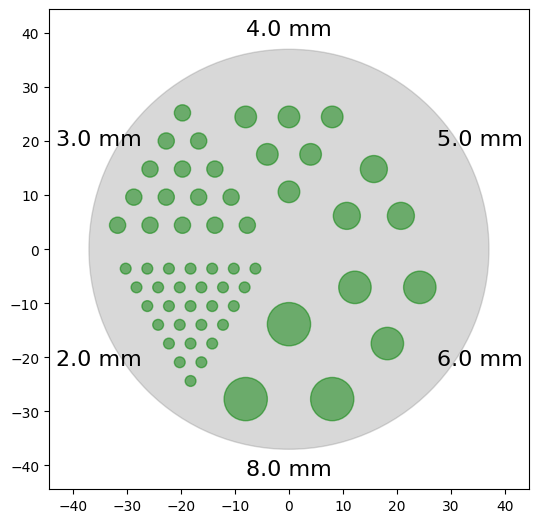

ic| my_mask.sum(): 4593168.0


In [3]:
class DerenzoPhantom(object):
    """
    Describes a cylindrical Derenzo phantom.
    """
    # Always subdivided into six sections, 60 degrees per section
    _num_sections = 6
    def __init__(self, radius, well_separations, cyl_height=0, unit="mm"):
        """
        Create a Derenzo phantom based on the input parameters.

        A circle with radius is partitioned into six equal sections.
        Each section is then populated with circular 'wells' that have a
        diameter and spacing defined by well_separations.

        Note the kwargs 'cyl_height' and 'unit' are only relevant if phantom is
        used to generate a Geant4 general point source macro.

        Parameters
        ----------
        radius : float
            The radius of the phantom

        well_separations : array_like, 1D, with len == 6
            A sequence specifying the well diameters and separations in each
            of the six sections.
            Sequence must contain 6 numeric elements.

        cyl_height : float, default: 0
            Depth of the wells in the phantom. All wells have the same depth.
            If 0, then the phantom is 2D.

        unit : string
            Unit of length for all relevant measurements. Default is 'mm'.
            Can be any valid unit for length from G4SystemOfUnits.hh

        Examples
        --------
        >>> radius = 50.0
        >>> well_seps = (10.0, 8.0, 6.0, 4.0, 2.0, 1.0)
        >>> my_phantom = DerenzoPhantom(radius, well_seps)
        """
        self.radius = radius
        self.well_seps = well_separations
        self.depth = cyl_height
        self.unit = unit

        # Define sections
        self.sections = []
        for well_sep, rot_angle in zip(self.well_seps,
                                       np.arange(0, 360., 360. / self._num_sections)):
            section = DerenzoSection(self.radius, well_sep)
            section.apply_rotation(rot_angle)
            self.sections.append(section)

        # Initialize mask
        self.mask=np.zeros((1024, 1024)).flatten()
        self.mask_scale=(2.*self.radius)/1024.
        self.xlinspace=np.linspace(-self.radius, self.radius, 1024)
        self.ylinspace=np.linspace(-self.radius, self.radius, 1024)
        xgrid,ygrid = np.meshgrid(self.xlinspace, self.ylinspace)
        self.xgrid=xgrid.flatten()
        self.ygrid=ygrid.flatten()

        # Initialize graphic (values hard-coded for now)
        self.fig = plt.figure(figsize=(6, 6))           # Aspect ratio = 1
        self.ax = self.fig.add_axes([0.1, 0.1, 0.8, 0.8])
        self.cyl_patch = mpp.Circle((0, 0), radius=self.radius, color='gray',
                                    alpha=0.3)
        self.ax.add_patch(self.cyl_patch)
        self.ax.set_xlim((-1.2*self.radius, 1.2*self.radius))
        self.ax.set_ylim((-1.2*self.radius, 1.2*self.radius))

        # Plot well locations from all sections of the phantom
        for section in self.sections:
            SectorMask=section.mask_and_plot_wells(self.fig, self.ax)
            ic(SectorMask.sum())
            self.mask=self.mask+SectorMask
            ic(self.mask.sum())

    @property
    def area(self):
        return np.sum([s.total_area for s in self.sections])

    @property
    def num_wells(self):
        return np.sum([s.num_wells for s in self.sections])

    def show(self):
        """
        Render and display the MPL model of the phantom.
        """
        self.fig.canvas.draw()
        plt.show()

    def mask(self):
        return self.mask.reshape((1024,1024))

    def export_to_G4gps_macro(self, fname, num_events, gamma_en,
                              event_mode='equal_activity'):
        """
        Generate a Geant4 general particle source macro for the phantom
        instance.

        Event mode determines how many events per well. Options are:
         - 'equal_activity': Behaves as if the wells are filled with a solution
                             of constant activity/volume, thus the events per
                             well is the total number of events divided by
                             the area ratio of the cell.
         - 'equal_counts'  : Divides the total number of events by the number
                             of wells. Usefull for accentuating smaller
                             features for testing reconstruction.
        """
        with open(fname, 'w') as fh:
            for section in self.sections:
                # Determine the number of events to run for each cell in section
                if event_mode == 'equal_activity':
                    ne = num_events * (section.well_area / self.area)
                elif event_mode == 'equal_counts':
                    ne = num_events / self.num_wells
                elif event_mode == 'subsection_area':
                    ne = num_events * (section.total_area / self.area)
                else:
                    raise ValueError("'event_mode' not understood.")
                # TODO: add & test Poisson sampling
                # Add a GPS source for each well
                for xy in section.locs:
                    export_to_G4mac(fh, xy[0], xy[1], 0, section.r, gamma_en,
                                    ne, halfz=self.depth)

class DerenzoSection(object):
    """
    One of six sub-sections of the Derenzo phantom.
    """
    def __init__(self, phantom_radius, well_separation, section_offset=0.1):
        """
        phantom_radius = radius of containing phantom
        well_separation = distance between wells (and well diameter!)
        section_offset = fraction of phantom radius that is used as a buffer
                         zone between adjacent sections.
        """
        self.R = phantom_radius
        self.well_sep = well_separation
        self.r = self.well_sep / 2.0
        self.section_offset = self.R * section_offset
        # Determine well locations
        self.place_wells_in_section()
        # Location for section label
        self.label_xy = np.array((0, -1.1 * self.R))
        # Mask for section
        # Initialize mask
        self.mask=np.zeros((1024, 1024)).flatten()
        self.mask_scale=(2.*self.R)/1024.
        self.xlinspace=np.linspace(-self.R, self.R, 1024)
        self.ylinspace=np.linspace(-self.R, self.R, 1024)
        xgrid,ygrid = np.meshgrid(self.xlinspace, self.ylinspace)
        self.xgrid=xgrid.flatten()
        self.ygrid=ygrid.flatten()
    @property
    def row_height(self):
        return self.well_sep * np.sqrt(3)

    @property
    def num_rows(self):
        h_section = self.R - (2 * self.section_offset + self.well_sep)
        return int(np.floor(h_section / self.row_height))

    @property
    def num_wells(self):
        return np.sum(1 + np.arange(self.num_rows))

    @property
    def well_area(self):
        return np.pi * self.r**2

    @property
    def total_area(self):
        return self.num_wells * self.well_area

    @property
    def label(self):
        return "%.1f mm" %(self.well_sep)

    def place_wells_in_section(self):
        """
        Method analogous to derenzo_log.place_wells_in_section
        """
        # If only one (or no) wells fit in section, try reducing section offset
        # in attempt to squeeze more in.
        #NOTE: Could add property called 'placement_policy' or something like
        # that which governs this behavior
        if self.num_rows <= 1:
            self.section_offset = 0.0
            if self.num_rows <= 1:
                warnings.warn(("Cannot fit multiple features in section with "
                               "feature size = %s" %(self.well_sep)))
        xs, ys = [], []
        for i in range(self.num_rows):
            rn = i + 1
            for x in np.arange(-rn, rn, 2) + 1:
                xs.append(x * self.well_sep)
                ys.append(-(self.section_offset + self.row_height * rn))
        self.locs = np.vstack((xs, ys)).T

    def apply_rotation(self, deg):
        """
        Rotate well locations around central (z) axis by 'deg' degrees.

        deg > 0: Counter-clockwise | deg < 0: clockwise
        """
        self.rot_angle = deg
        th = -1 * deg * (np.pi / 180)
        rot_mat = np.array([(np.cos(th), -np.sin(th)),
                            (np.sin(th),  np.cos(th))])
        # Rotate well locations
        self.locs = np.array([np.dot(l, rot_mat) for l in self.locs])
        # Rotate label location
        self.label_xy = np.dot(self.label_xy, rot_mat)

    def mask_and_plot_wells(self, fig, ax):
        """
        Plot the well pattern for the given section on the input figure and
        axis handles.
        """
        # Plot wells
        for xy in self.locs:
            cyl = mpp.Circle(xy, radius=self.r, color="green", alpha=0.5)
            # mask wells
            where = np.where((self.xgrid-xy[0])**2 + (self.ygrid-xy[1])**2 <= self.R**2)
            self.mask[where] = 1
            # Plot
            ax.add_patch(cyl)

        # Add label
        x, y = self.label_xy
        ax.text(x, y, self.label, horizontalalignment='center',
                verticalalignment='center', fontsize=16)

        return(self.mask)

if __name__ == "__main__":
    radius = 37.0
    well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)
    #
    # Initialize mask
    mask=np.zeros((1024, 1024))
    xlinspace=np.linspace(-radius, radius, 1024)
    ylinspace=np.linspace(-radius, radius, 1024)
    xgrid,ygrid = np.meshgrid(xlinspace, ylinspace)
    xgrid=xgrid.flatten()
    ygrid=ygrid.flatten()

    my_phantom = DerenzoPhantom(radius, well_seps)
    my_phantom.show()
    my_mask=my_phantom.mask
    ic(my_mask.sum())
    #


Leave input parameters same and call again

ic| SectorMask.sum(): 740998.0
ic| self.mask.sum(): 740998.0
ic| SectorMask.sum(): 709031.0
ic| self.mask.sum(): 1450029.0
ic| SectorMask.sum(): 734963.0
ic| self.mask.sum(): 2184992.0
ic| SectorMask.sum(): 787934.0
ic| self.mask.sum(): 2972926.0
ic| SectorMask.sum(): 795618.0
ic| self.mask.sum(): 3768544.0
ic| SectorMask.sum(): 824624.0
ic| self.mask.sum(): 4593168.0


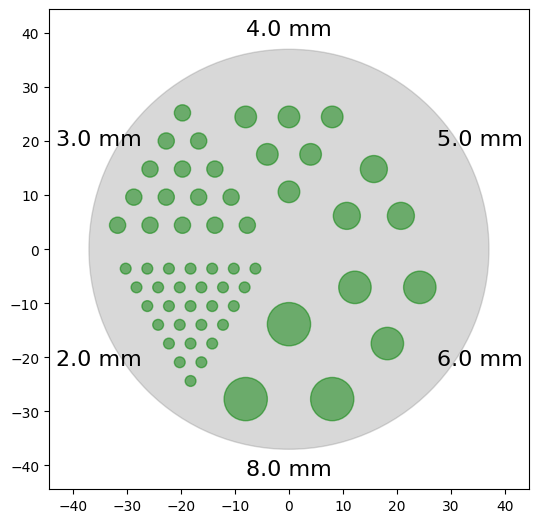

In [4]:
radius = 37.0
well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)
test_phantom = DerenzoPhantom(radius, well_seps)
test_phantom.show()

Change input parameters and call again

ic| SectorMask.sum(): 763206.0
ic| self.mask.sum(): 763206.0
ic| SectorMask.sum(): 752127.0
ic| self.mask.sum(): 1515333.0
ic| SectorMask.sum(): 765602.0
ic| self.mask.sum(): 2280935.0
ic| SectorMask.sum(): 800240.0
ic| self.mask.sum(): 3081175.0
ic| SectorMask.sum(): 795618.0
ic| self.mask.sum(): 3876793.0
ic| SectorMask.sum(): 810148.0
ic| self.mask.sum(): 4686941.0


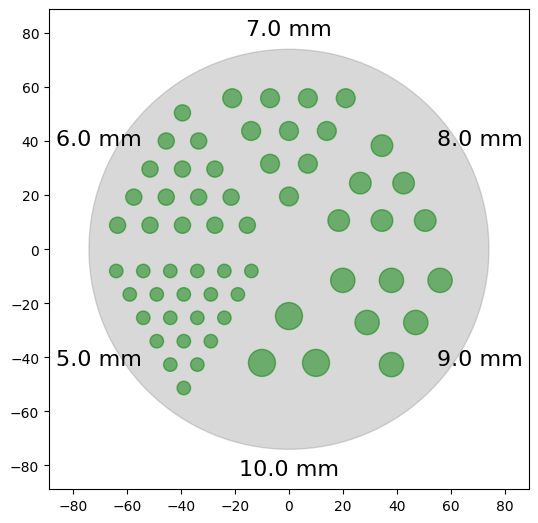

In [5]:
radius = 74.0
well_seps = (10.0, 9.0, 8.0, 7.0, 6.0, 5.0)
my_phantom = DerenzoPhantom(radius, well_seps)
my_phantom.show()

A typical heart is approximately the size of your fist: 12 cm in length, 8 cm wide, and 6 cm in thickness.

Big high resolution phantom

ic| SectorMask.sum(): 800240.0
ic| self.mask.sum(): 800240.0
ic| SectorMask.sum(): 795618.0
ic| self.mask.sum(): 1595858.0
ic| SectorMask.sum(): 810148.0
ic| self.mask.sum(): 2406006.0
ic| SectorMask.sum(): 837122.0
ic| self.mask.sum(): 3243128.0
ic| SectorMask.sum(): 839541.0
ic| self.mask.sum(): 4082669.0
ic| SectorMask.sum(): 854361.0
ic| self.mask.sum(): 4937030.0


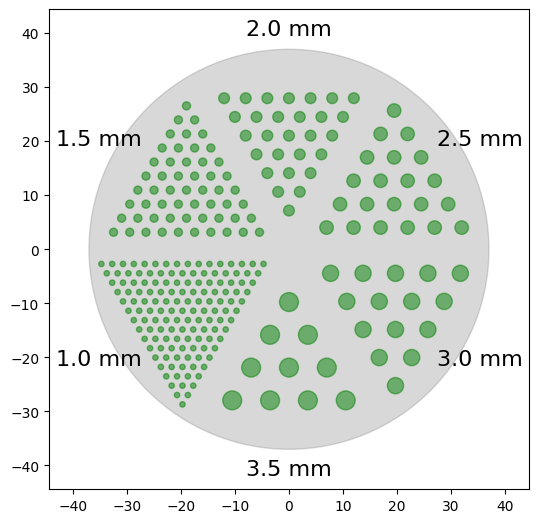

In [6]:
radius = 37.0
well_seps = (3.5, 3.0, 2.5, 2.0, 1.5, 1.0)
big_phantom = DerenzoPhantom(radius, well_seps)
big_phantom.show()

DerenzoPhantom -> myDerenzoPhantom

From phantom.py

Use original phantom

ic| SectorMask.sum(): 740998.0
ic| self.mask.sum(): 740998.0
ic| SectorMask.sum(): 709031.0
ic| self.mask.sum(): 1450029.0
ic| SectorMask.sum(): 734963.0
ic| self.mask.sum(): 2184992.0
ic| SectorMask.sum(): 787934.0
ic| self.mask.sum(): 2972926.0
ic| SectorMask.sum(): 795618.0
ic| self.mask.sum(): 3768544.0
ic| SectorMask.sum(): 824624.0
ic| self.mask.sum(): 4593168.0


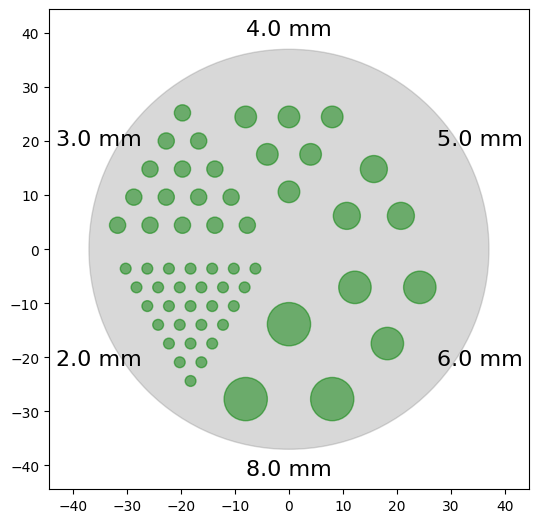

In [7]:
radius = 37.0
well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)
test_phantom = DerenzoPhantom(radius, well_seps)
test_phantom.show()

Check mask generation

ic| SectorMask.sum(): 24658.0
ic| self.mask.sum(): 24658.0
ic| SectorMask.sum(): 22252.0
ic| self.mask.sum(): 46910.0
ic| SectorMask.sum(): 19974.0
ic| self.mask.sum(): 66884.0
ic| SectorMask.sum(): 17804.0
ic| self.mask.sum(): 84688.0
ic| SectorMask.sum(): 15777.0
ic| self.mask.sum(): 100465.0
ic| SectorMask.sum(): 13852.0
ic| self.mask.sum(): 114317.0


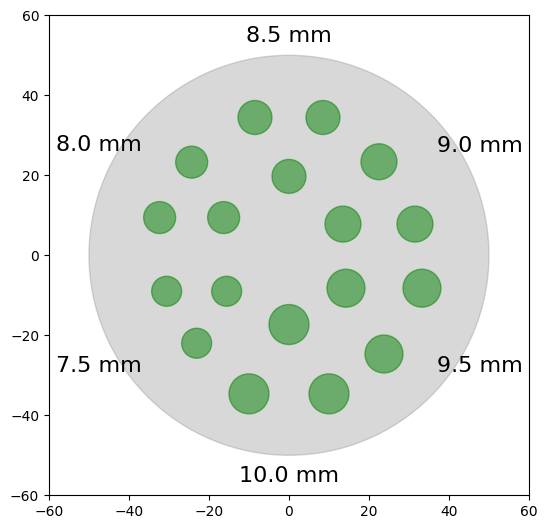

ic| my_mask.sum(): 114317.0


In [8]:
class DerenzoPhantom(object):
    """
    Describes a cylindrical Derenzo phantom.
    """
    # Always subdivided into six sections, 60 degrees per section
    _num_sections = 6
    def __init__(self, radius, well_separations, cyl_height=0, unit="mm"):
        """
        Create a Derenzo phantom based on the input parameters.

        A circle with radius is partitioned into six equal sections.
        Each section is then populated with circular 'wells' that have a
        diameter and spacing defined by well_separations.

        Note the kwargs 'cyl_height' and 'unit' are only relevant if phantom is
        used to generate a Geant4 general point source macro.

        Parameters
        ----------
        radius : float
            The radius of the phantom

        well_separations : array_like, 1D, with len == 6
            A sequence specifying the well diameters and separations in each
            of the six sections.
            Sequence must contain 6 numeric elements.

        cyl_height : float, default: 0
            Depth of the wells in the phantom. All wells have the same depth.
            If 0, then the phantom is 2D.

        unit : string
            Unit of length for all relevant measurements. Default is 'mm'.
            Can be any valid unit for length from G4SystemOfUnits.hh

        Examples
        --------
        >>> radius = 50.0
        >>> well_seps = (10.0, 8.0, 6.0, 4.0, 2.0, 1.0)
        >>> my_phantom = DerenzoPhantom(radius, well_seps)
        """
        self.radius = radius
        self.well_seps = well_separations
        self.depth = cyl_height
        self.unit = unit

        # Define sections
        self.sections = []
        for well_sep, rot_angle in zip(self.well_seps,
                                       np.arange(0, 360., 360. / self._num_sections)):
            section = DerenzoSection(self.radius, well_sep)
            section.apply_rotation(rot_angle)
            self.sections.append(section)

        # Initialize mask
        self.mask=np.zeros((1024, 1024)).flatten()
        self.mask_scale=(2.*self.radius)/1024.
        self.xlinspace=np.linspace(-self.radius, self.radius, 1024)
        self.ylinspace=np.linspace(-self.radius, self.radius, 1024)
        xgrid,ygrid = np.meshgrid(self.xlinspace, self.ylinspace)
        self.xgrid=xgrid.flatten()
        self.ygrid=ygrid.flatten()

        # Initialize graphic (values hard-coded for now)
        self.fig = plt.figure(figsize=(6, 6))           # Aspect ratio = 1
        self.ax = self.fig.add_axes([0.1, 0.1, 0.8, 0.8])
        self.cyl_patch = mpp.Circle((0, 0), radius=self.radius, color='gray',
                                    alpha=0.3)
        self.ax.add_patch(self.cyl_patch)
        self.ax.set_xlim((-1.2*self.radius, 1.2*self.radius))
        self.ax.set_ylim((-1.2*self.radius, 1.2*self.radius))

        # Plot well locations from all sections of the phantom
        for section in self.sections:
            SectorMask=section.mask_and_plot_wells(self.fig, self.ax)
            ic(SectorMask.sum())
            self.mask=self.mask+SectorMask
            ic(self.mask.sum())

    @property
    def area(self):
        return np.sum([s.total_area for s in self.sections])

    @property
    def num_wells(self):
        return np.sum([s.num_wells for s in self.sections])

    def show(self):
        """
        Render and display the MPL model of the phantom.
        """
        self.fig.canvas.draw()
        plt.show()

    def mask(self):
        return self.mask.reshape((1024,1024))

    def export_to_G4gps_macro(self, fname, num_events, gamma_en,
                              event_mode='equal_activity'):
        """
        Generate a Geant4 general particle source macro for the phantom
        instance.

        Event mode determines how many events per well. Options are:
         - 'equal_activity': Behaves as if the wells are filled with a solution
                             of constant activity/volume, thus the events per
                             well is the total number of events divided by
                             the area ratio of the cell.
         - 'equal_counts'  : Divides the total number of events by the number
                             of wells. Usefull for accentuating smaller
                             features for testing reconstruction.
        """
        with open(fname, 'w') as fh:
            for section in self.sections:
                # Determine the number of events to run for each cell in section
                if event_mode == 'equal_activity':
                    ne = num_events * (section.well_area / self.area)
                elif event_mode == 'equal_counts':
                    ne = num_events / self.num_wells
                elif event_mode == 'subsection_area':
                    ne = num_events * (section.total_area / self.area)
                else:
                    raise ValueError("'event_mode' not understood.")
                # TODO: add & test Poisson sampling
                # Add a GPS source for each well
                for xy in section.locs:
                    export_to_G4mac(fh, xy[0], xy[1], 0, section.r, gamma_en,
                                    ne, halfz=self.depth)

class DerenzoSection(object):
    """
    One of six sub-sections of the Derenzo phantom.
    """
    def __init__(self, phantom_radius, well_separation, section_offset=0.1):
        """
        phantom_radius = radius of containing phantom
        well_separation = distance between wells (and well diameter!)
        section_offset = fraction of phantom radius that is used as a buffer
                         zone between adjacent sections.
        """
        self.R = phantom_radius
        self.well_sep = well_separation
        self.r = self.well_sep / 2.0
        self.section_offset = self.R * section_offset
        # Determine well locations
        self.place_wells_in_section()
        # Location for section label
        self.label_xy = np.array((0, -1.1 * self.R))
        # Mask for section
        # Initialize mask
        self.mask=np.zeros((1024, 1024)).flatten()
        self.xlinspace=np.linspace(-self.R, self.R, 1024)
        self.ylinspace=np.linspace(-self.R, self.R, 1024)
        xgrid,ygrid = np.meshgrid(self.xlinspace, self.ylinspace)
        self.xgrid=xgrid.flatten()
        self.ygrid=ygrid.flatten()
    @property
    def row_height(self):
        return self.well_sep * np.sqrt(3)

    @property
    def num_rows(self):
        h_section = self.R - (2 * self.section_offset + self.well_sep)
        return int(np.floor(h_section / self.row_height))

    @property
    def num_wells(self):
        return np.sum(1 + np.arange(self.num_rows))

    @property
    def well_area(self):
        return np.pi * self.r**2

    @property
    def total_area(self):
        return self.num_wells * self.well_area

    @property
    def label(self):
        return "%.1f mm" %(self.well_sep)

    def place_wells_in_section(self):
        """
        Method analogous to derenzo_log.place_wells_in_section
        """
        # If only one (or no) wells fit in section, try reducing section offset
        # in attempt to squeeze more in.
        #NOTE: Could add property called 'placement_policy' or something like
        # that which governs this behavior
        if self.num_rows <= 1:
            self.section_offset = 0.0
            if self.num_rows <= 1:
                warnings.warn(("Cannot fit multiple features in section with "
                               "feature size = %s" %(self.well_sep)))
        xs, ys = [], []
        for i in range(self.num_rows):
            rn = i + 1
            for x in np.arange(-rn, rn, 2) + 1:
                xs.append(x * self.well_sep)
                ys.append(-(self.section_offset + self.row_height * rn))
        self.locs = np.vstack((xs, ys)).T

    def apply_rotation(self, deg):
        """
        Rotate well locations around central (z) axis by 'deg' degrees.

        deg > 0: Counter-clockwise | deg < 0: clockwise
        """
        self.rot_angle = deg
        th = -1 * deg * (np.pi / 180)
        rot_mat = np.array([(np.cos(th), -np.sin(th)),
                            (np.sin(th),  np.cos(th))])
        # Rotate well locations
        self.locs = np.array([np.dot(l, rot_mat) for l in self.locs])
        # Rotate label location
        self.label_xy = np.dot(self.label_xy, rot_mat)

    def mask_and_plot_wells(self, fig, ax):
        """
        Plot the well pattern for the given section on the input figure and
        axis handles.
        """
        xlinspace=np.linspace(-self.R, self.R, 1024)
        ylinspace=np.linspace(-self.R, self.R, 1024)
        xgrid,ygrid = np.meshgrid(xlinspace, ylinspace)
        xgrid=xgrid.flatten()
        ygrid=ygrid.flatten()

        # Plot wells
        for xy in self.locs:
            cyl = mpp.Circle(xy, radius=self.r, color="green", alpha=0.5)
            #ic(xy)
            #ic(self.r)
            # mask wells
            where = np.where((xgrid-xy[0])**2 + (ygrid-xy[1])**2 <= self.r**2)
            self.mask[where] = 1
            #ic(self.mask.sum())
            # Plot
            ax.add_patch(cyl)

        # Add label
        x, y = self.label_xy
        ax.text(x, y, self.label, horizontalalignment='center',
                verticalalignment='center', fontsize=16)

        return(self.mask)

if __name__ == "__main__":
    radius = 50.0
    well_seps = (10.0,9.5, 9.0, 8.5, 8.0, 7.5)
    #
    # Initialize mask
    mask=np.zeros((1024, 1024))
    xlinspace=np.linspace(-radius, radius, 1024)
    ylinspace=np.linspace(-radius, radius, 1024)
    xgrid,ygrid = np.meshgrid(xlinspace, ylinspace)
    xgrid=xgrid.flatten()
    ygrid=ygrid.flatten()

    my_phantom = DerenzoPhantom(radius, well_seps)
    my_phantom.show()
    my_mask=my_phantom.mask
    ic(my_mask.sum())
    #


ic| SectorMask.sum(): 28818.0
ic| self.mask.sum(): 28818.0
ic| SectorMask.sum(): 16216.0
ic| self.mask.sum(): 45034.0
ic| SectorMask.sum(): 11257.0
ic| self.mask.sum(): 56291.0
ic| SectorMask.sum(): 14414.0
ic| self.mask.sum(): 70705.0
ic| SectorMask.sum(): 20275.0
ic| self.mask.sum(): 90980.0
ic| SectorMask.sum(): 16790.0
ic| self.mask.sum(): 107770.0


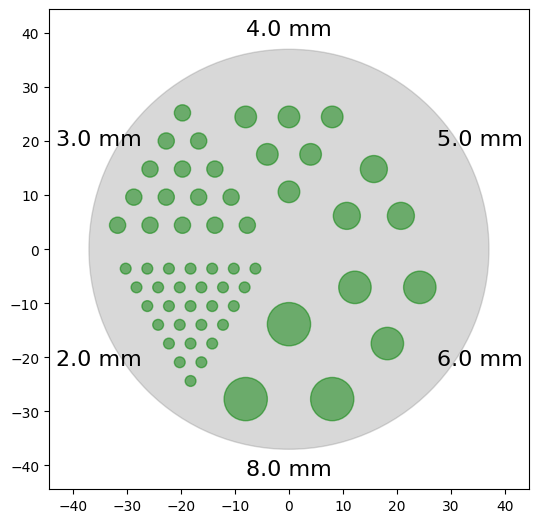

In [9]:
radius = 37.0
well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)
test_phantom = DerenzoPhantom(radius, well_seps)
test_phantom.show()

Generate Mask for reference phantom

ic| myMask.shape: (1024, 1024)
ic| myMask.sum(): 107770.0


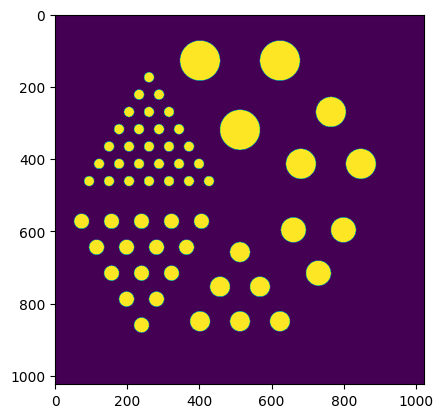

In [10]:
myMask=test_phantom.mask.reshape(1024,1024)
ic(myMask.shape)
ic(myMask.sum())
plt.imshow(myMask)

A typical heart is approximately the size of your fist: 12 cm in length, 8 cm wide, and 6 cm in thickness.

Big high resolution phantom

ic| SectorMask.sum(): 18392.0
ic| self.mask.sum(): 18392.0
ic| SectorMask.sum(): 20275.0
ic| self.mask.sum(): 38667.0
ic| SectorMask.sum(): 19710.0
ic| self.mask.sum(): 58377.0
ic| SectorMask.sum(): 16778.0
ic| self.mask.sum(): 75155.0
ic| SectorMask.sum(): 18587.0
ic| self.mask.sum(): 93742.0
ic| SectorMask.sum(): 20356.0
ic| self.mask.sum(): 114098.0


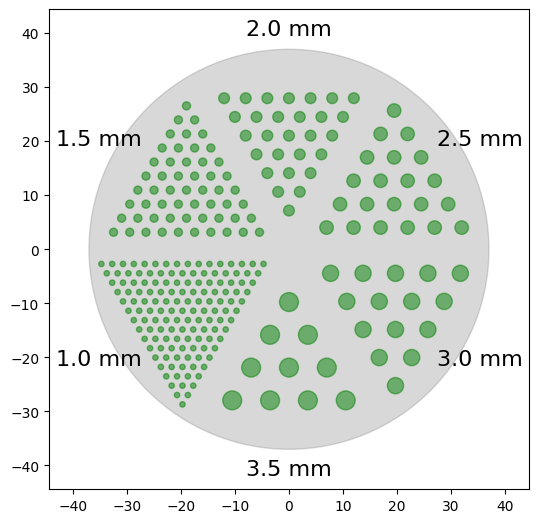

In [11]:
radius = 37.0
well_seps = (3.5, 3.0, 2.5, 2.0, 1.5, 1.0)
big_phantom = DerenzoPhantom(radius, well_seps)
big_phantom.show()

Generate Mask for Big High Resolution phantom

ic| bigMask.shape: (1024, 1024)
ic| bigMask.sum(): 114098.0


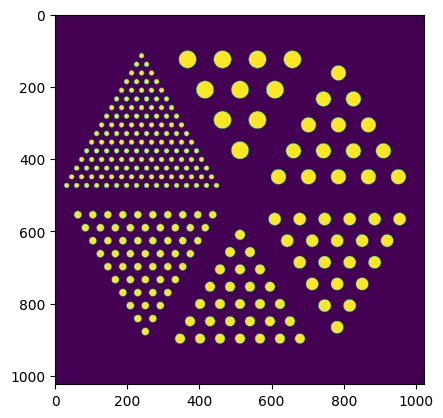

In [12]:
bigMask=big_phantom.mask.reshape(1024,1024)
ic(bigMask.shape)
ic(bigMask.sum())
plt.imshow(bigMask)